<a href="https://colab.research.google.com/github/Maram00ali/REV4RE/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydot==1.4.2

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score


from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

2023-03-28 17:36:08.267792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 17:36:08.369573: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 17:36:08.374280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 17:36:08.374294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [ ]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.10.0


In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF
2023-03-28 17:36:14.538889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 17:36:14.539487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-28 17:36:14.539500: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 17:36:14.539513: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-378be7ce-053e-4e53-a8d7-d43f011c835b): /proc/driver/nvidia/version does not exist


****
Let us define methods to pre-process the review data
****

In [ ]:



def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))])

    return text2.lower()



***

Let us pre-process the data

***

In [ ]:
review_data= pd.read_csv("dataset path")
print(review_data.head(10))
print(len(review_data))


                                              Review  RivewRelevance
0                                    5 star good app               1
1                A monthly subscription fee. Really?               1
2  Able to customize and decorate a ton of things...               1
3           All I can say is this game is the best!!               1
4  Although not the best, it better for own creat...               1
5  asks literally every time you open the app if ...               1
6  Awesome tool for home owners, realtors, design...               1
7  Been using for a few hours so far, it’s not us...               2
8  Bored at home dont know what to do?\n\nGet thi...               1
9  Dear Room Planner\nI love this app so much!You...               1
84932


In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True)





#review_data['reviewText'] = review_data['reviewText'].apply(remove_url)
review_data['reviewText'] = review_data['Review'].apply(clean_text)
review_data['Num_words_text'] = review_data['Review'].apply(lambda x:len(str(x).split()))

print('-------Dataset --------')
print(review_data['RivewRelevance'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))


#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Dataset --------
1    69045
0    10352
2     5535
Name: RivewRelevance, dtype: int64
84932
-------------------------
Train Max Sentence Length :1189


In [ ]:
review_data['Num_words_text'].describe()

count    84932.000000
mean        26.388758
std         32.159515
min          3.000000
25%          8.000000
50%         16.000000
75%         33.000000
max       1189.000000
Name: Num_words_text, dtype: float64

<AxesSubplot: xlabel='Num_words_text'>

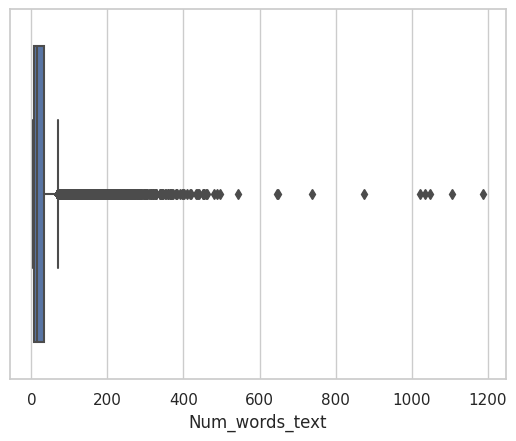

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

***
Let us create a dataset having reviews of 100 words or less
***

In [ ]:
mask = (review_data['Num_words_text'] < 400) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 400
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
35804
No of Long reviews
27


In [ ]:
print(df_short_reviews['Num_words_text'].max())

398


In [ ]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0


***
Let us create our train and test datasets
***

In [ ]:
#df_short_reviews['rating'].value_counts()
filtered_data = df_short_reviews.groupby('RivewRelevance').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['RivewRelevance'].value_counts())
#filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=35804, random_state =0)
train_data = filtered_data[['Review','RivewRelevance']]
print('Train data')
print(train_data['RivewRelevance'].value_counts())

#Create Test Data
mask = review_data['Num_words_text'] < 100
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('RivewRelevance').filter(lambda x: len(x) >= 10)
print(filtered_data ['RivewRelevance'].value_counts())
#filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=35804, random_state =0)
test_data = filtered_data[['Review','RivewRelevance']]
print('Test data')
print(test_data['RivewRelevance'].value_counts())




35804
1    27985
2     4133
0     3686
Name: RivewRelevance, dtype: int64
Train data
1    27985
2     4133
0     3686
Name: RivewRelevance, dtype: int64
1    67503
0    10060
2     4823
Name: RivewRelevance, dtype: int64
Test data
1    67503
0    10060
2     4823
Name: RivewRelevance, dtype: int64


In [ ]:
train_data['RivewRelevance'].value_counts()

1    27985
2     4133
0     3686
Name: RivewRelevance, dtype: int64

Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['Review'].tolist(),\
                                                      train_data['RivewRelevance'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['RivewRelevance'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:17902
Class distributionCounter({1: 13992, 2: 2067, 0: 1843})
Valid data len:17902
Class distributionCounter({1: 13993, 2: 2066, 0: 1843})


***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))




[[10346, 82, 27, 11]]


***
Let us create our train,validation and test tensorflow datasets
***

In [ ]:



x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['Review'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['RivewRelevance'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


/tmp/ipykernel_903/4257519400.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
/tmp/ipykernel_903/4257519400.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
/tmp/ipykernel_903/4257519400.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[ 352  312 1999   15 2903   12 1043   15  193   25    7  207   16  444
 2600   52 1666   15 1031    8 1361    5  939    5   58 5013 1666    2
   17  141   97   50   10   23   16    9  658    4   24   12    3 1412
   51    9  381    6 3929   12  414  260  273  107  115    2   40   15
  193   12    7  161    5   75    6 2323   24  127   68 6467    5 1999
  336    8 1380   19    3 1362 2903   18    2  195   69 1204  336  750
 3487   24    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[   34    70     4   618    12     7   259    30   562   806  1511    14
   142    20    52  1729   122    71   103   636    23   352 12817   384
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0    

****
Let us create a simple LSTM based sentiment classification  model  
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture[1] used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition,[2] speech recognition[3][4] and anomaly detection in network traffic or IDSs (intrusion detection systems).
https://en.wikipedia.org/wiki/Long_short-term_memory

For futher reading :https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

****




![450px-The_LSTM_cell.png](attachment:450px-The_LSTM_cell.png)

****
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 2.0
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
****

In [ ]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))




model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

![Architecture.png](attachment:Architecture.png)

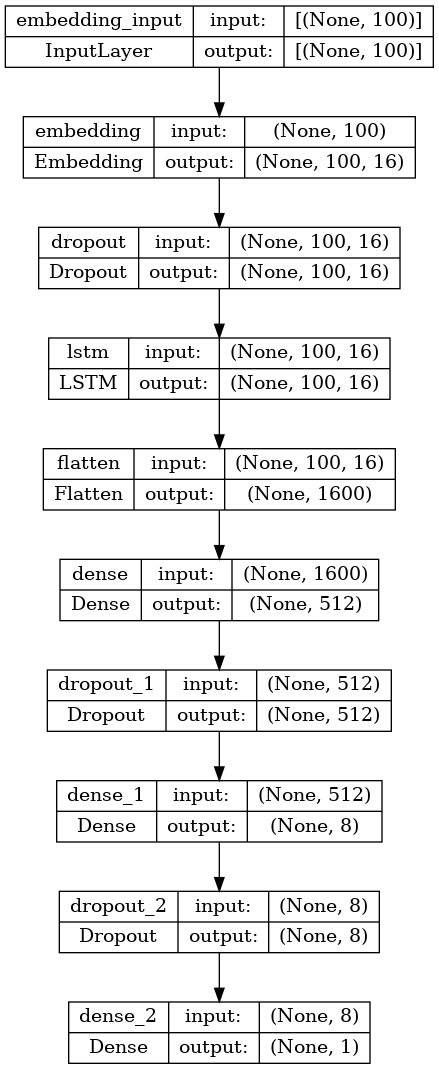

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

***
Let's train our model
***

In [ ]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(32),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(32),
                    verbose=1)

Epoch 1/10
18/18 [==============================] - 7s 256ms/step - loss: 3.1041 - binary_accuracy: 0.7560 - val_loss: 1.4920 - val_binary_accuracy: 0.7816
Epoch 2/10
18/18 [==============================] - 4s 239ms/step - loss: 0.6475 - binary_accuracy: 0.7816 - val_loss: -0.5640 - val_binary_accuracy: 0.7816
Epoch 3/10
18/18 [==============================] - 4s 249ms/step - loss: -3.6052 - binary_accuracy: 0.7812 - val_loss: -10.5970 - val_binary_accuracy: 0.7816
Epoch 4/10
18/18 [==============================] - 4s 240ms/step - loss: -43.0102 - binary_accuracy: 0.7847 - val_loss: -115.7222 - val_binary_accuracy: 0.8077
Epoch 5/10
18/18 [==============================] - 4s 237ms/step - loss: -252.0286 - binary_accuracy: 0.8138 - val_loss: -424.5983 - val_binary_accuracy: 0.8181
Epoch 6/10
18/18 [==============================] - 4s 239ms/step - loss: -713.0195 - binary_accuracy: 0.8237 - val_loss: -981.0256 - val_binary_accuracy: 0.8279
Epoch 7/10
18/18 [=========================

In [ ]:
history.history


{'loss': [3.1041178703308105,
  0.647479236125946,
  -3.605175495147705,
  -43.010189056396484,
  -252.02857971191406,
  -713.0194702148438,
  -1585.5205078125,
  -2845.84765625,
  -4426.791015625,
  -6388.03857421875],
 'binary_accuracy': [0.7560049295425415,
  0.7815886735916138,
  0.7811976075172424,
  0.784716784954071,
  0.8138197064399719,
  0.8236510157585144,
  0.8242654204368591,
  0.822589635848999,
  0.8270584344863892,
  0.8266115784645081],
 'val_loss': [1.492043375968933,
  -0.5639911890029907,
  -10.59703540802002,
  -115.72219848632812,
  -424.59832763671875,
  -981.0255737304688,
  -1875.609619140625,
  -3092.529296875,
  -4626.45849609375,
  -6473.693359375],
 'val_binary_accuracy': [0.7816445231437683,
  0.7816445231437683,
  0.7816445231437683,
  0.8077309727668762,
  0.8180650472640991,
  0.8278962969779968,
  0.8252708911895752,
  0.8279522061347961,
  0.8186794519424438,
  0.8268349766731262]}

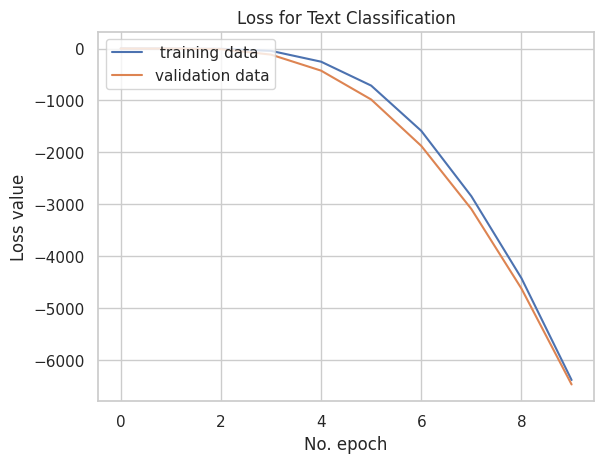

In [ ]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

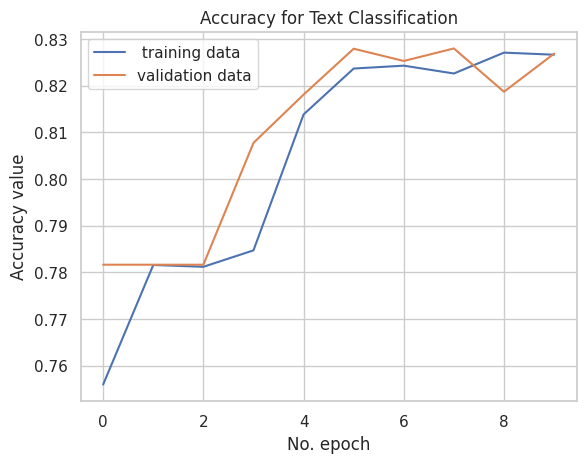

In [ ]:


plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


Lets save our model and tokenizer

In [ ]:
model.save('C:\\AppReviews\\savedTFLSTMModel\\tf_lstmmodel.h5')
json_string = tokenizer.to_json()


In [ ]:
import json
with open('C:\\AppReviews\\savedTFLSTMModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)


In [ ]:
valid_predict= model.predict(x_valid)

560/560 [==============================] - 5s 9ms/step


In [ ]:
print(valid_predict[:10])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


***
Code from : https://stackoverflow.com/questions/22518230/creating-a-threshold-coded-roc-plot-in-python

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The method was developed for operators of military radar receivers, which is why it is so named

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

***

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
#plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')

ValueError: multiclass format is not supported

Lets load our model and test on test data

In [ ]:
new_model = tf.keras.models.load_model('C:\\AppReviews\\savedTFLSTMModel\\tf_lstmmodel.h5')
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [ ]:
with open('C:\\AppReviews\\savedTFLSTMModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['Review'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

/tmp/ipykernel_903/2965490106.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(test_data['Review'].tolist()) )


In [ ]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)



Generate predictions for all samples
2575/2575 [==============================] - 24s 9ms/step


In [ ]:
test_data['pred_Relvence']= predictions
test_data['pred_Relvence'] = np.where((test_data.pred_Relvence >= 0.78),1,test_data.pred_Relvence)
test_data['pred_Relvence'] = np.where((test_data.pred_Relvence < 0.78),0,test_data.pred_Relvence)


/tmp/ipykernel_903/2426244008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_Relvence']= predictions
/tmp/ipykernel_903/2426244008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_Relvence'] = np.where((test_data.pred_Relvence >= 0.78),1,test_data.pred_Relvence)
/tmp/ipykernel_903/2426244008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
test_data

,Review,RivewRelevance,pred_Relvence
0,5 star good app,1,0.0
1,A monthly subscription fee. Really?,1,1.0
2,Able to customize and decorate a ton of things...,1,1.0
3,All I can say is this game is the best!!,1,1.0
4,"Although not the best, it better for own creat...",1,1.0
...,...,...,...
84927,Your app sucks.Im deleting it.I know I'm not g...,1,1.0
84928,Your app wait along the process of downloads a...,1,1.0
84929,Your customer service is the most unresponsive...,1,1.0
84930,Your new desktop version sucks. I can save or ...,1,1.0


In [ ]:
labels = [0,1,2]

print(accuracy_score(test_data['RivewRelevance'], test_data['pred_Relvence']))
print(classification_report(test_data['RivewRelevance'].tolist(),test_data['pred_Relvence'].tolist(),labels=labels))

0.7349671060617096
              precision    recall  f1-score   support

           0       0.33      0.75      0.46     10060
           1       0.89      0.78      0.83     67503
           2       0.00      0.00      0.00      4823

    accuracy                           0.73     82386
   macro avg       0.41      0.51      0.43     82386
weighted avg       0.77      0.73      0.74     82386

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=378be7ce-053e-4e53-a8d7-d43f011c835b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>